## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

# store camera calibration parameters in ./camera_cal/calibrated_data.p
CAMERA_CALIBRATION_COEFFICIENTS_FILE = './camera_cal/calibrated_data.p'

class CameraCalibrator:
    def __init__(self, calibration_images, x_corners, y_corners, init_coef=True):
 
        
        # images used for camera calibration
        self.calibration_images = calibration_images
        
        # The number of horizontal corners in calibration images
        self.x_corners = x_corners
        
        # The number of vertical corners in calibration images
        self.y_corners = y_corners
        self.object_points = []
        self.image_points = []

        if not init_coef:
            self._calibrate()

    def _calibrate(self):
        """

        :return:
            Camera calibration coefficients as a python dictionary
        """
        object_point = np.zeros((self.x_corners * self.y_corners, 3), np.float32)
        object_point[:,:2] = np.mgrid[0:self.x_corners, 0:self.y_corners].T.reshape(-1, 2)

        for idx, file_name in enumerate(self.calibration_images):
            image = cv2.imread(file_name)
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            ret, corners = cv2.findChessboardCorners(gray_image,(self.x_corners, self.y_corners),None)
            if ret:
                self.object_points.append(object_point)
                self.image_points.append(corners)
        h, w = image.shape[:2]
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.object_points, self.image_points, (w, h), None, None)

        calibrated_data = {'mtx': mtx, 'dist': dist}

        with open(CAMERA_CALIBRATION_COEFFICIENTS_FILE, 'wb') as f:
            pickle.dump(calibrated_data, file=f)

    def undistort(self, image):
        """

        :param image:
        :return:
        """

        if not os.path.exists(CAMERA_CALIBRATION_COEFFICIENTS_FILE):
            raise Exception('Camera calibration data file does not exist at ' +
                            CAMERA_CALIBRATION_COEFFICIENTS_FILE)

        with open(CAMERA_CALIBRATION_COEFFICIENTS_FILE, 'rb') as f:
            calibrated_data = pickle.load(file=f)

        return cv2.undistort(image, calibrated_data['mtx'], calibrated_data['dist'],None, calibrated_data['mtx'])


##  1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
## 2. Apply a distortion correction to raw images.

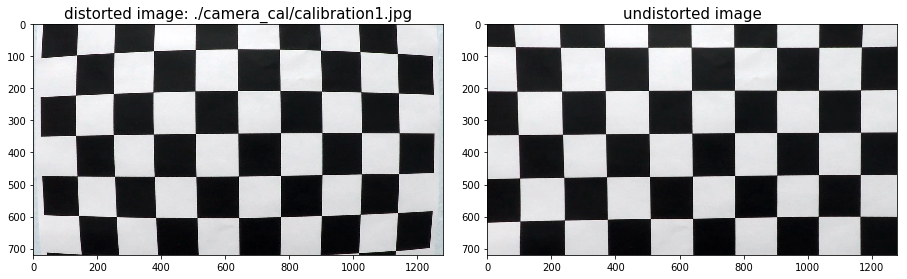

In [20]:
%matplotlib inline
# Make a list of calibration images

calibration_images = glob.glob('./camera_cal/calibration*.jpg')
calibrator = CameraCalibrator(calibration_images, 9, 6, init_coef = False)

# Take example distorted image and undistort it using saved camera coefficients
fname = './camera_cal/calibration1.jpg'
distorted_image = cv2.imread(fname)
undistorted_image = calibrator.undistort(distorted_image)

# Display both distorted and undistorted images
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()

ax1.imshow(distorted_image)
ax1.set_title('distorted image: ./camera_cal/calibration1.jpg', fontsize=15)

ax2.imshow(undistorted_image,cmap='gray')
ax2.set_title('undistorted image', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Apply a perspective transform to rectify binary image ("birds-eye view").

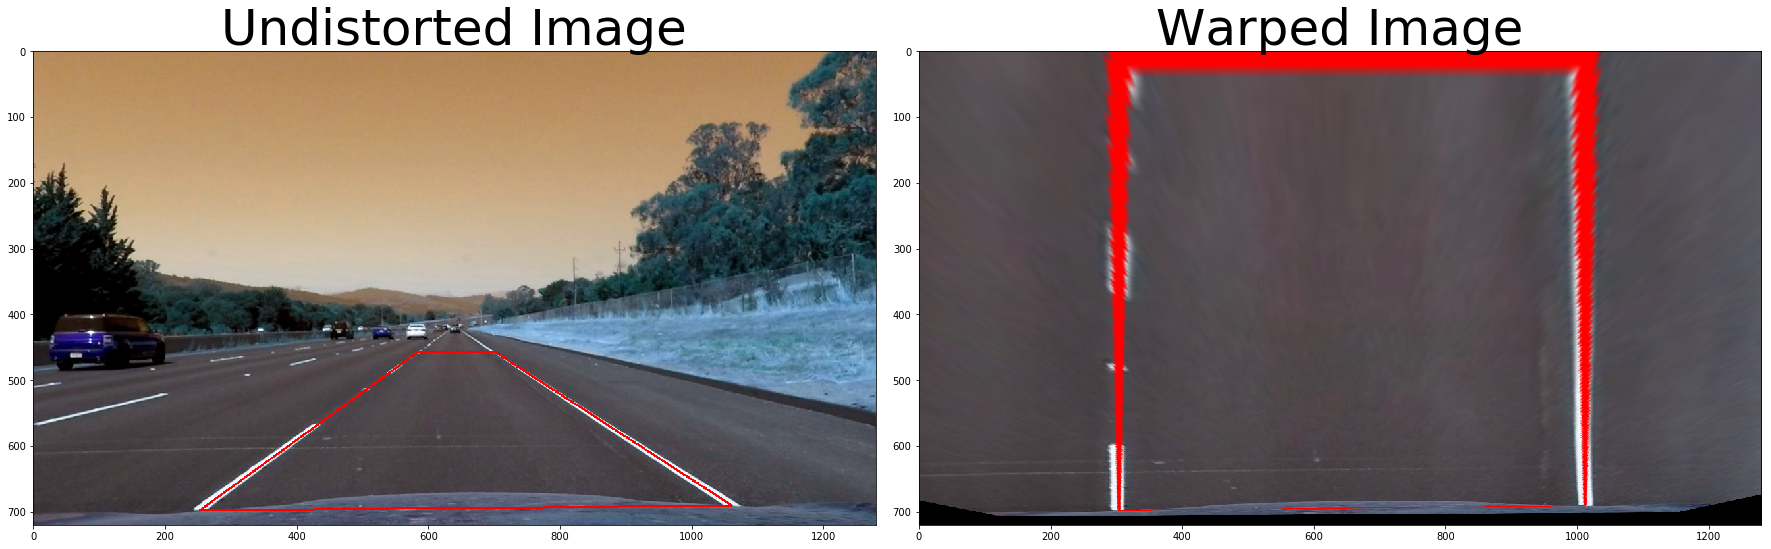

In [21]:
import matplotlib.image as mpimg
%matplotlib inline

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def unwarp(img):

    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    # e) use cv2.warpPerspective() to warp your image to a top-down view

    img_size = (img.shape[1],img.shape[0])
    
    # Four source coordinates (left_bottom, left_top, right_top, right_bottom) from  test_images/straight_lines2.jpg
    #src = np.float32([[259, 683], [597, 447], [686, 447], [1063, 683]])

    # Four dstination coordinates
    #dst = np.float32([[259,683],[259,0],[1063,0],[1063,683]])
    #'''
    corners = np.float32([[253, 697],[585,456],[700, 456],[1061,690]])
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    
    img_size = (image.shape[1], image.shape[0])
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    #'''
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

fname = 'test_images/straight_lines2.jpg'
image = cv2.imread(fname)
undistorted_image = calibrator.undistort(image)
cv2.imwrite('test_images/straight_lines2_undistorted.png',undistorted_image, [int( cv2.IMWRITE_JPEG_QUALITY), 95])

# Choose 
#pts = np.array([[259, 683], [597, 447], [686, 447], [1063, 683]], np.int32)  
pts = np.array([[253, 697],[585,456],[700, 456],[1061,690]], np.int32)  
pts = pts.reshape((-1,1,2))
imd = np.copy(undistorted_image)
imd = cv2.polylines(imd,[pts],True,(255,0,0),2)  
cv2.imwrite('test_images/straight_lines2_undistorted_withpoints.png',imd, [int( cv2.IMWRITE_JPEG_QUALITY), 95])



binary_warped, perspective_M, Minv  = unwarp(imd)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imd)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(binary_warped,cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

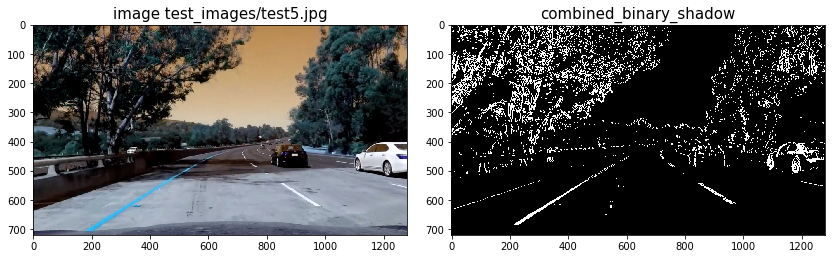

In [22]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt

def noise_reduction(image, threshold=4):
    """
    This method is used to reduce the noise of binary images.

    :param image:
        binary image (0 or 1)

    :param threshold:
        min number of neighbours with value

    :return:
    """
    
    k = np.array([[1, 1, 1],
                  [1, 0, 1],
                  [1, 1, 1]])
    nb_neighbours = cv2.filter2D(image, ddepth=-1, kernel=k)
    image[nb_neighbours < threshold] = 0
    return image

def binary_threshold_filter(channel, thresh = (200, 255), on = 1):
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = on
    return binary
    
# Edit this function to create your own pipeline.
def pipeline(img,hls_s_thresh = (170,255),
                 hls_l_thresh = (30,255),
                 sobel_thresh=(20,255),
                 mag_thresh=(70,100),
                 dir_thresh=(0.8,0.9),
                 r_thresh=(150,255),
                 u_thresh=(140,180)):
    
    img = np.copy(img)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Convert to HLS color space and separate the s channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    s_binary = binary_threshold_filter(s_channel,hls_s_thresh)
    l_binary = binary_threshold_filter(l_channel,hls_l_thresh)
        
    # Threshhold the R channel
    R = img[:,:,2]
    rbinary = binary_threshold_filter(R, r_thresh)
    
    # Threshhold the U channel
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    U = yuv[:,:,1]
    ubinary = binary_threshold_filter(U, u_thresh)
    
    # Take the derivative in x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = binary_threshold_filter(scaled_sobelx,sobel_thresh)

    
    # Take the derivative in y
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) 
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobely = np.absolute(sobely) 
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    # Threshold x gradient
    sybinary = binary_threshold_filter(scaled_sobely,sobel_thresh)
    
    
    # Calculate the gradient magnitude
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8) 
    mag_binary = binary_threshold_filter(grad_mag, mag_thresh)
    
    # Calculate the gradient direction, 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = binary_threshold_filter(absgraddir, dir_thresh)

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Filter shadow and preserve 
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((l_binary == 1) & (s_binary == 1) | (sxbinary == 1))] = 1
    
    return color_binary,noise_reduction(combined_binary)


# Use distortion image
fname = 'test_images/test5.jpg'
img_shadow = cv2.imread(fname)
undistorted_shadow = calibrator.undistort(img_shadow)
color_binary_shadow,combined_binary_shadow = pipeline(img_shadow)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
f.tight_layout()

ax1.imshow(undistorted_shadow)
ax1.set_title('image test_images/test5.jpg', fontsize=15)

ax2.imshow(combined_binary_shadow,cmap='gray')
ax2.set_title('combined_binary_shadow', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


In [ ]:
### test warp

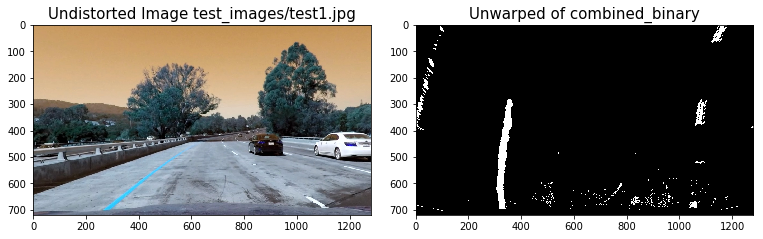

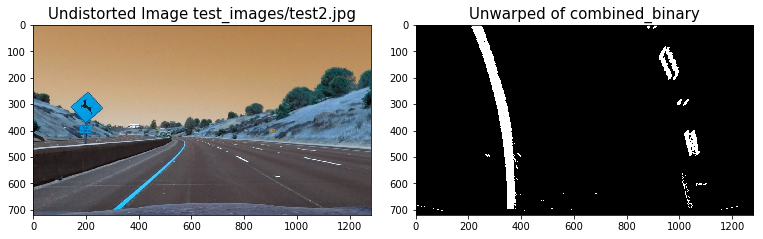

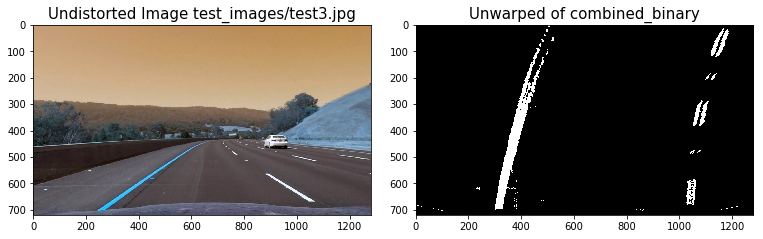

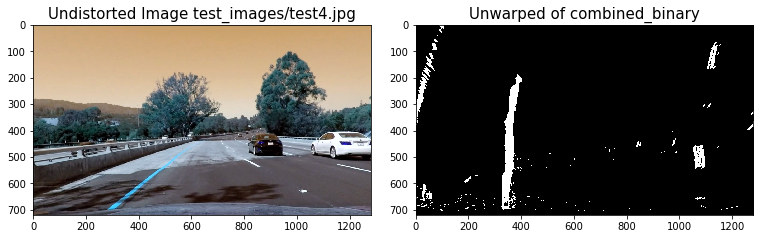

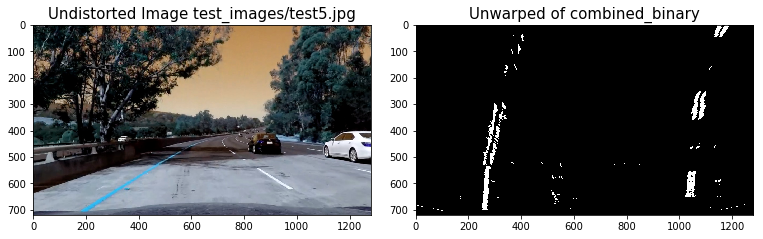

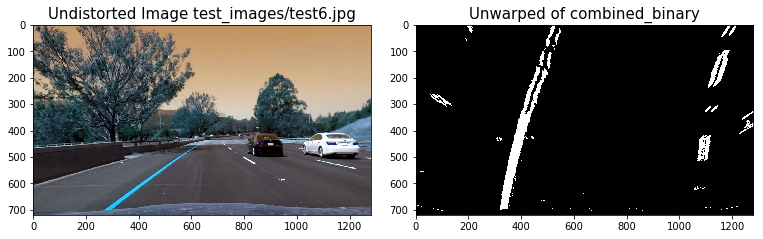

In [23]:
for i in range(1,7):
    
    fname = 'test_images/test'+str(i)+'.jpg'
    img = cv2.imread(fname)
    undistorted = calibrator.undistort(img)
    undistorted_unwarped, _, _ = unwarp(undistorted)
    color_binary,combined_binary = pipeline(undistorted_unwarped)
    img_size = (undistorted.shape[1],undistorted.shape[0])

    

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    f.tight_layout()
    ax1.imshow(undistorted)
    ax1.set_title('Undistorted Image ' + fname, fontsize=15)
    ax2.imshow(combined_binary,cmap='gray')
    ax2.set_title('Unwarped of combined_binary', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary.

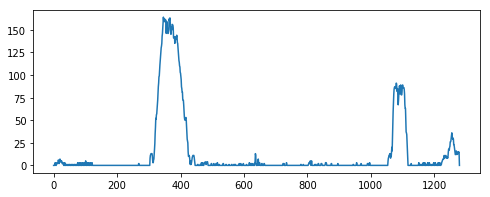

Peak point of left half: 346
Peak point of right half: 1080


In [42]:
fname = 'test_images/test6.jpg'
img = mpimg.imread(fname)
undistorted = calibrator.undistort(img)
undistorted_unwarped, _, _ = unwarp(undistorted)
color_binary,combined_binary = pipeline(undistorted_unwarped)
img_size = (undistorted.shape[1],undistorted.shape[0])

########################################
#  Implement Sliding Windows and Fit a Polynomial
#  Here is for first frame or need reobtain lane lines when lost lain lines
########################################

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
plt.figure(figsize=(8, 3))
plt.plot(histogram)
plt.show()


# Create an output image to draw on and  visualize the result
out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print('Peak point of left half: {}'.format(leftx_base))
print('Peak point of right half: {}'.format(rightx_base))

(720, 0)

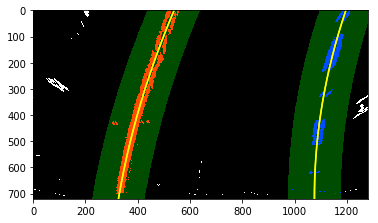

In [43]:


# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(combined_binary.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = combined_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = combined_binary.shape[0] - (window+1)*window_height
    win_y_high = combined_binary.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

########################################
#  Visualization
#
########################################

# Generate x and y values for plotting
ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

########################################
#  
#  Skip the sliding windows step once you know where the lines are
# This is equivalent to using a customized region of interest for each frame of video, and should help you track the lanes through sharp curves and tricky conditions. 
# If you lose track of the lines, go back to your sliding windows search or other method to rediscover them.
#
########################################

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = combined_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

########################################
#  
#  visualize
########################################

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Measuring Curvature

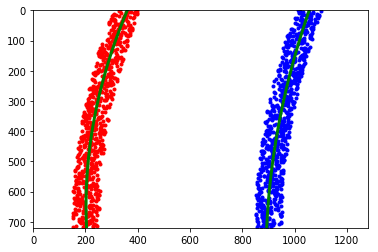

In [44]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

##  calculate the radius of curvature

In [45]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

1337.42874168 2077.39891087


### Calculation of radius of curvature after correcting for scale in x and y:

In [47]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/1280 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

437.437449867 m 679.604807936 m


In [ ]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### Sanity Check

In [ ]:
##Checking that they have similar curvature

### Look-Ahead Filter

### Reset

### Smoothing

### Drawing

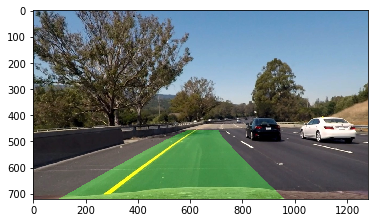

In [48]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
plt.imshow(result)